In [1]:
from drought.visualization import plot
from drought.data import pipeline
import matplotlib.pyplot as plt
import pandas as pd
from drought.data.aggregator import aggregate_number_of_shots
import seaborn as sns

### Get all GEDI Footprints for 8 polygons

In [2]:
footprints = pipeline.get_gedi_footprints()

### GEDI Availability

In [3]:
# Get number of footprints shots per month per year, stored in a 'number' column.
shot_distribution = aggregate_number_of_shots(footprints).set_index(['year', 'month', 'polygon_id'])

In [4]:
# Calculate means per polygon per month per year.
aggregate_pai = footprints.groupby(['year', 'month', 'polygon_id']).mean(numeric_only=True)

In [5]:
# join the number of shots with pai data
monthly = shot_distribution.join(aggregate_pai).reset_index()[['pai', 'number', 'year', 'month', 'polygon_id']]

In [6]:
def fill_timeseries_missing_data(df: pd.DataFrame, 
                                 values_to_fill: dict[str, str]):
    '''
    The .groupby() method used in aggregation will not account for any missing 
    months, so these are manually added as below so that it is easier to see 
    in the chart where data is lacking.
    '''
    df_copy = df.copy()
    for polygon in range(1,9):
        start = [2019, 4]
        end = [2022, 7]

        while start != end:
            if not ((df['year'] == start[0]) \
                    & (df['month'] == start[1]) \
                    & (df['polygon_id'] == polygon)).any():
                    
                    new_row_as_dict = {'year': start[0], 
                                       'month': start[1], 
                                       'polygon_id': polygon} \
                                       | values_to_fill
                    df_copy = df_copy.append(new_row_as_dict, 
                                             ignore_index = True)
            
            if start[1] != 12:
                start[1] += 1
            else:
                start[0] += 1
                start [1] = 1
    return df_copy

In [8]:
monthly_filled = fill_timeseries_missing_data(monthly, {'number': 0})

/tmp/ipykernel_3266490/799270879.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_copy = df_copy.append(new_row_as_dict,
/tmp/ipykernel_3266490/799270879.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_copy = df_copy.append(new_row_as_dict,
/tmp/ipykernel_3266490/799270879.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_copy = df_copy.append(new_row_as_dict,
/tmp/ipykernel_3266490/799270879.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_copy = df_copy.append(new_row_as_dict,
/tmp/ipykernel_3266490/799270879.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

The resulting df needs to be sorted by year and month so that the x axis of the chart will show months in the correct order. Additionally, year and month columns are converted to proper datetime objects. 

In [9]:
def add_date_column(df: pd.DataFrame):
    df = df.sort_values(by=['year','month'])

    df['date'] = pd.to_datetime(df['year'].astype(str) + 
                                df['month'] .astype(str),
                                format = '%Y%m').dt.strftime('%m-%y')
    return df

In [10]:
monthly_filled = add_date_column(monthly_filled)

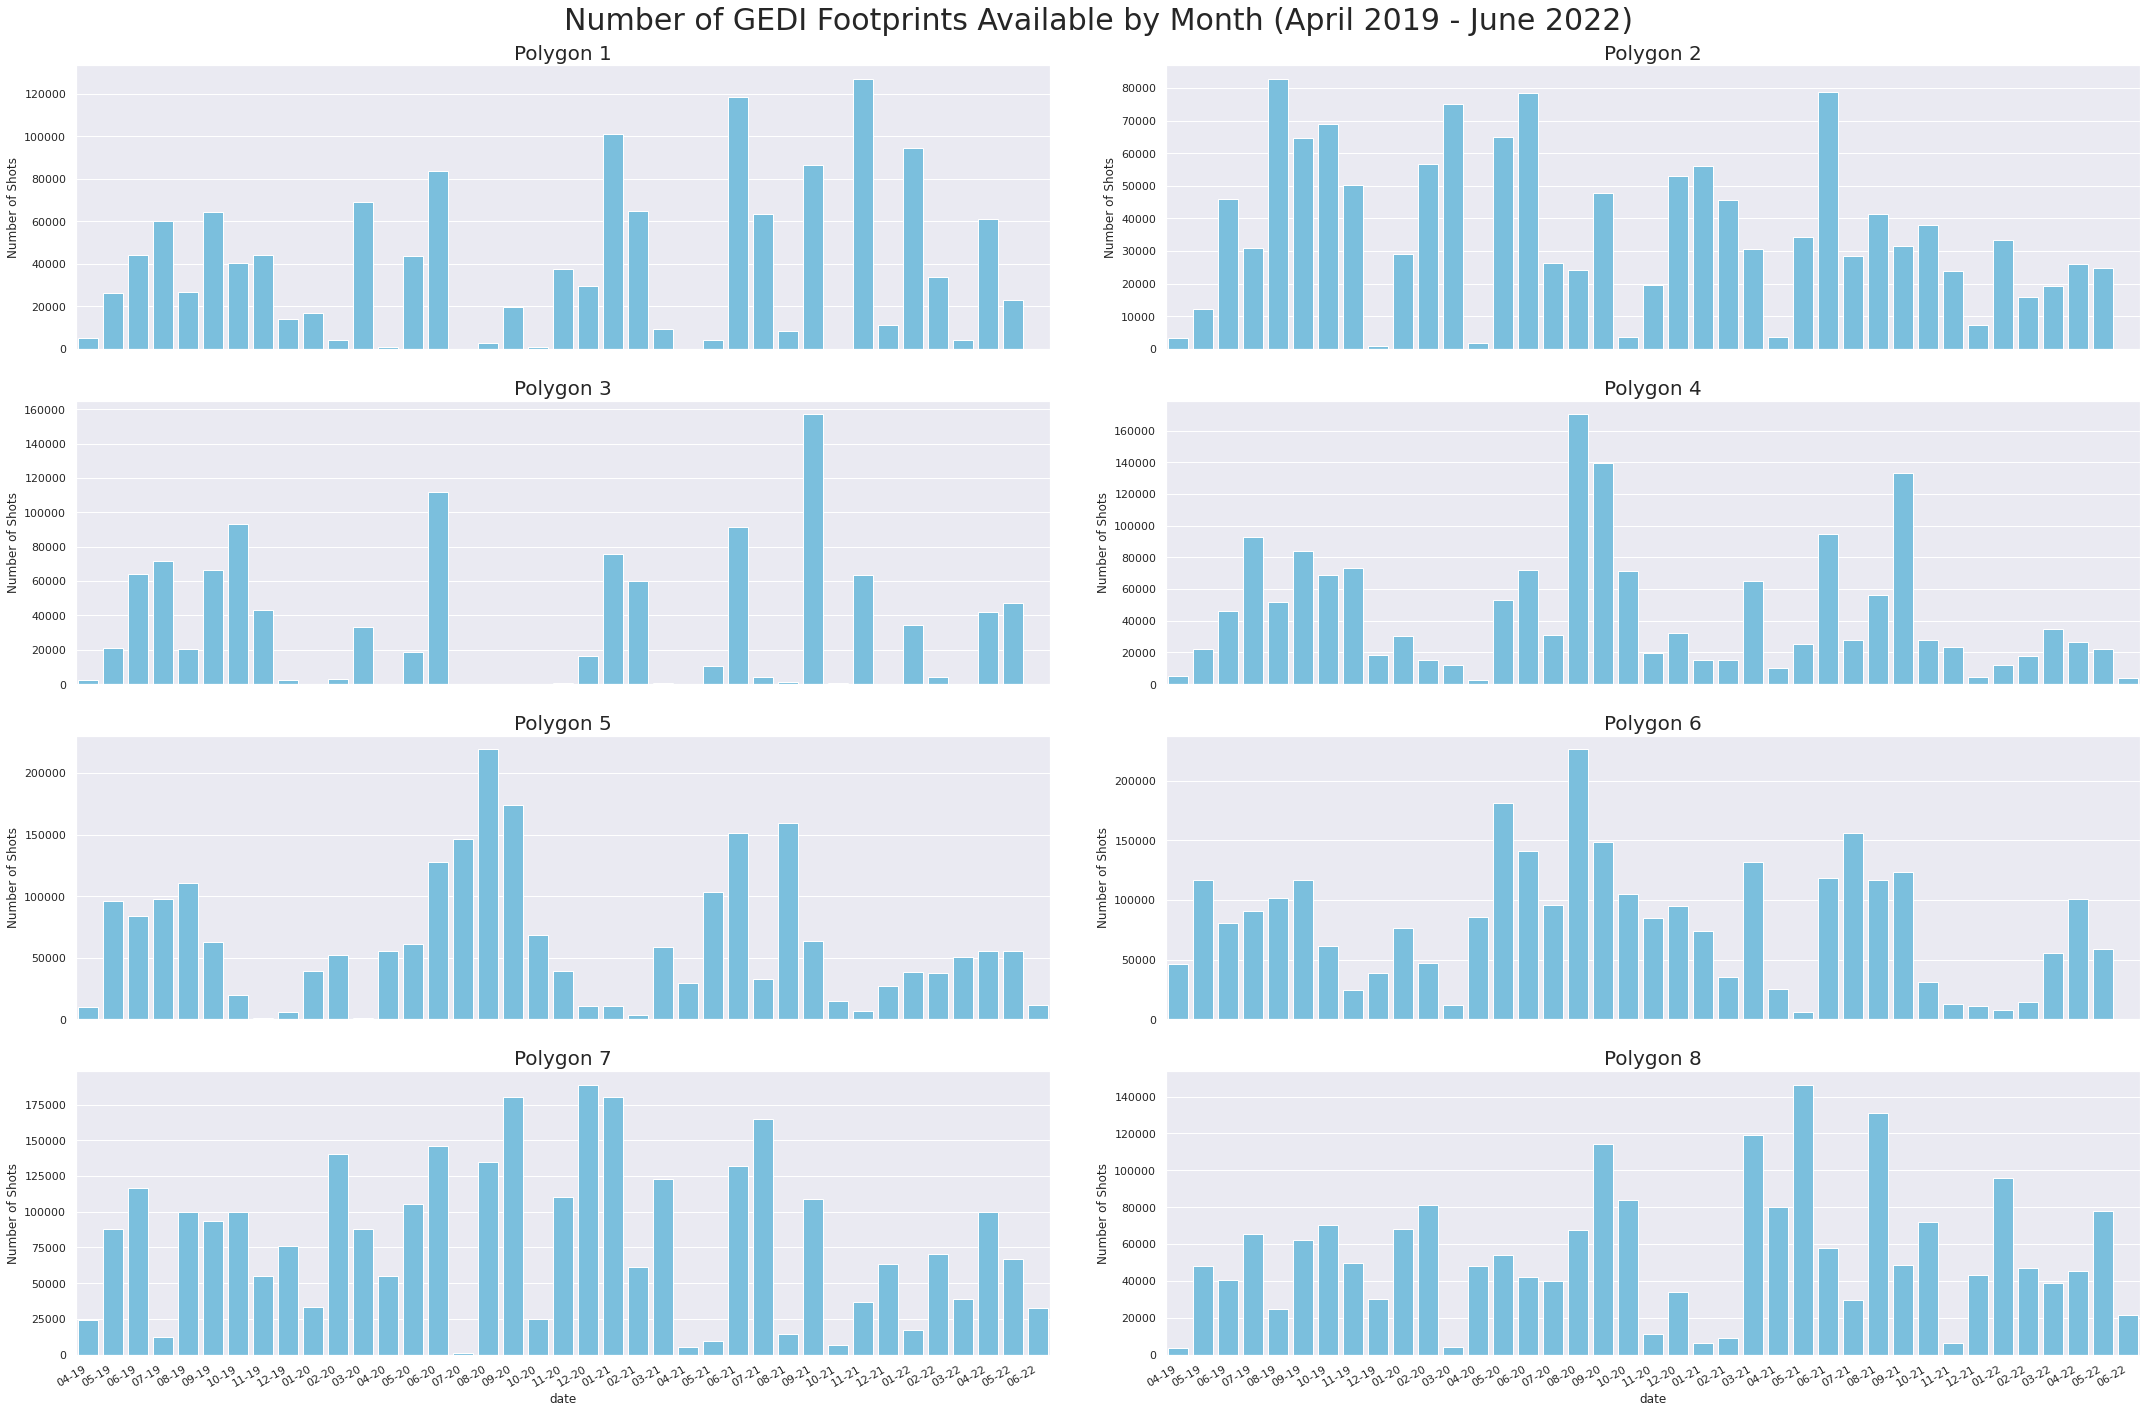

In [11]:
fig, ax = plot.barplot_per_polygon(monthly_filled, 
                                   x='date',
                                   y='number',
                                   ylabel ='Number of Shots',
                                   title="Number of GEDI Footprints Available by Month (April 2019 - June 2022)") # noqa: E501

fig.autofmt_xdate()

In the plot below, we plot the number of GEDI shots for that month vs. the mean PAI value for the month. If there are no GEDI shots for the entire month, we will have missing PAI data. We can see in the plot the missing data where the orange line has the breaks in.

Polygon 3 misses a lot of months in 2020, and Polygon 1 is missing 2 months in total. The rest of the polygons have non-zero shots for each month.

We can note as well that value of PAI in some months is out of line with the PAI values in the adjacent months. These usually correlate with months in which we have fewer GEDI shots. Some obvious outliers are:
* Polygon 1
  *  10-2020
* Polygon 2
  * 04-2019
  * 12-2019
  * 04-2020
* Polygon 3 - many, and much data is missing
* Polygon 4
  * 04-2020
  * 06-2022
* Polygon 5
  * 11-2019
  * 03-2020
* Polygon 6
  * 06-2022
* Polygon 7
  * 07-2020
  * 05-2021
* Polygon 8
  * 03-2020
  * 01-2021
  

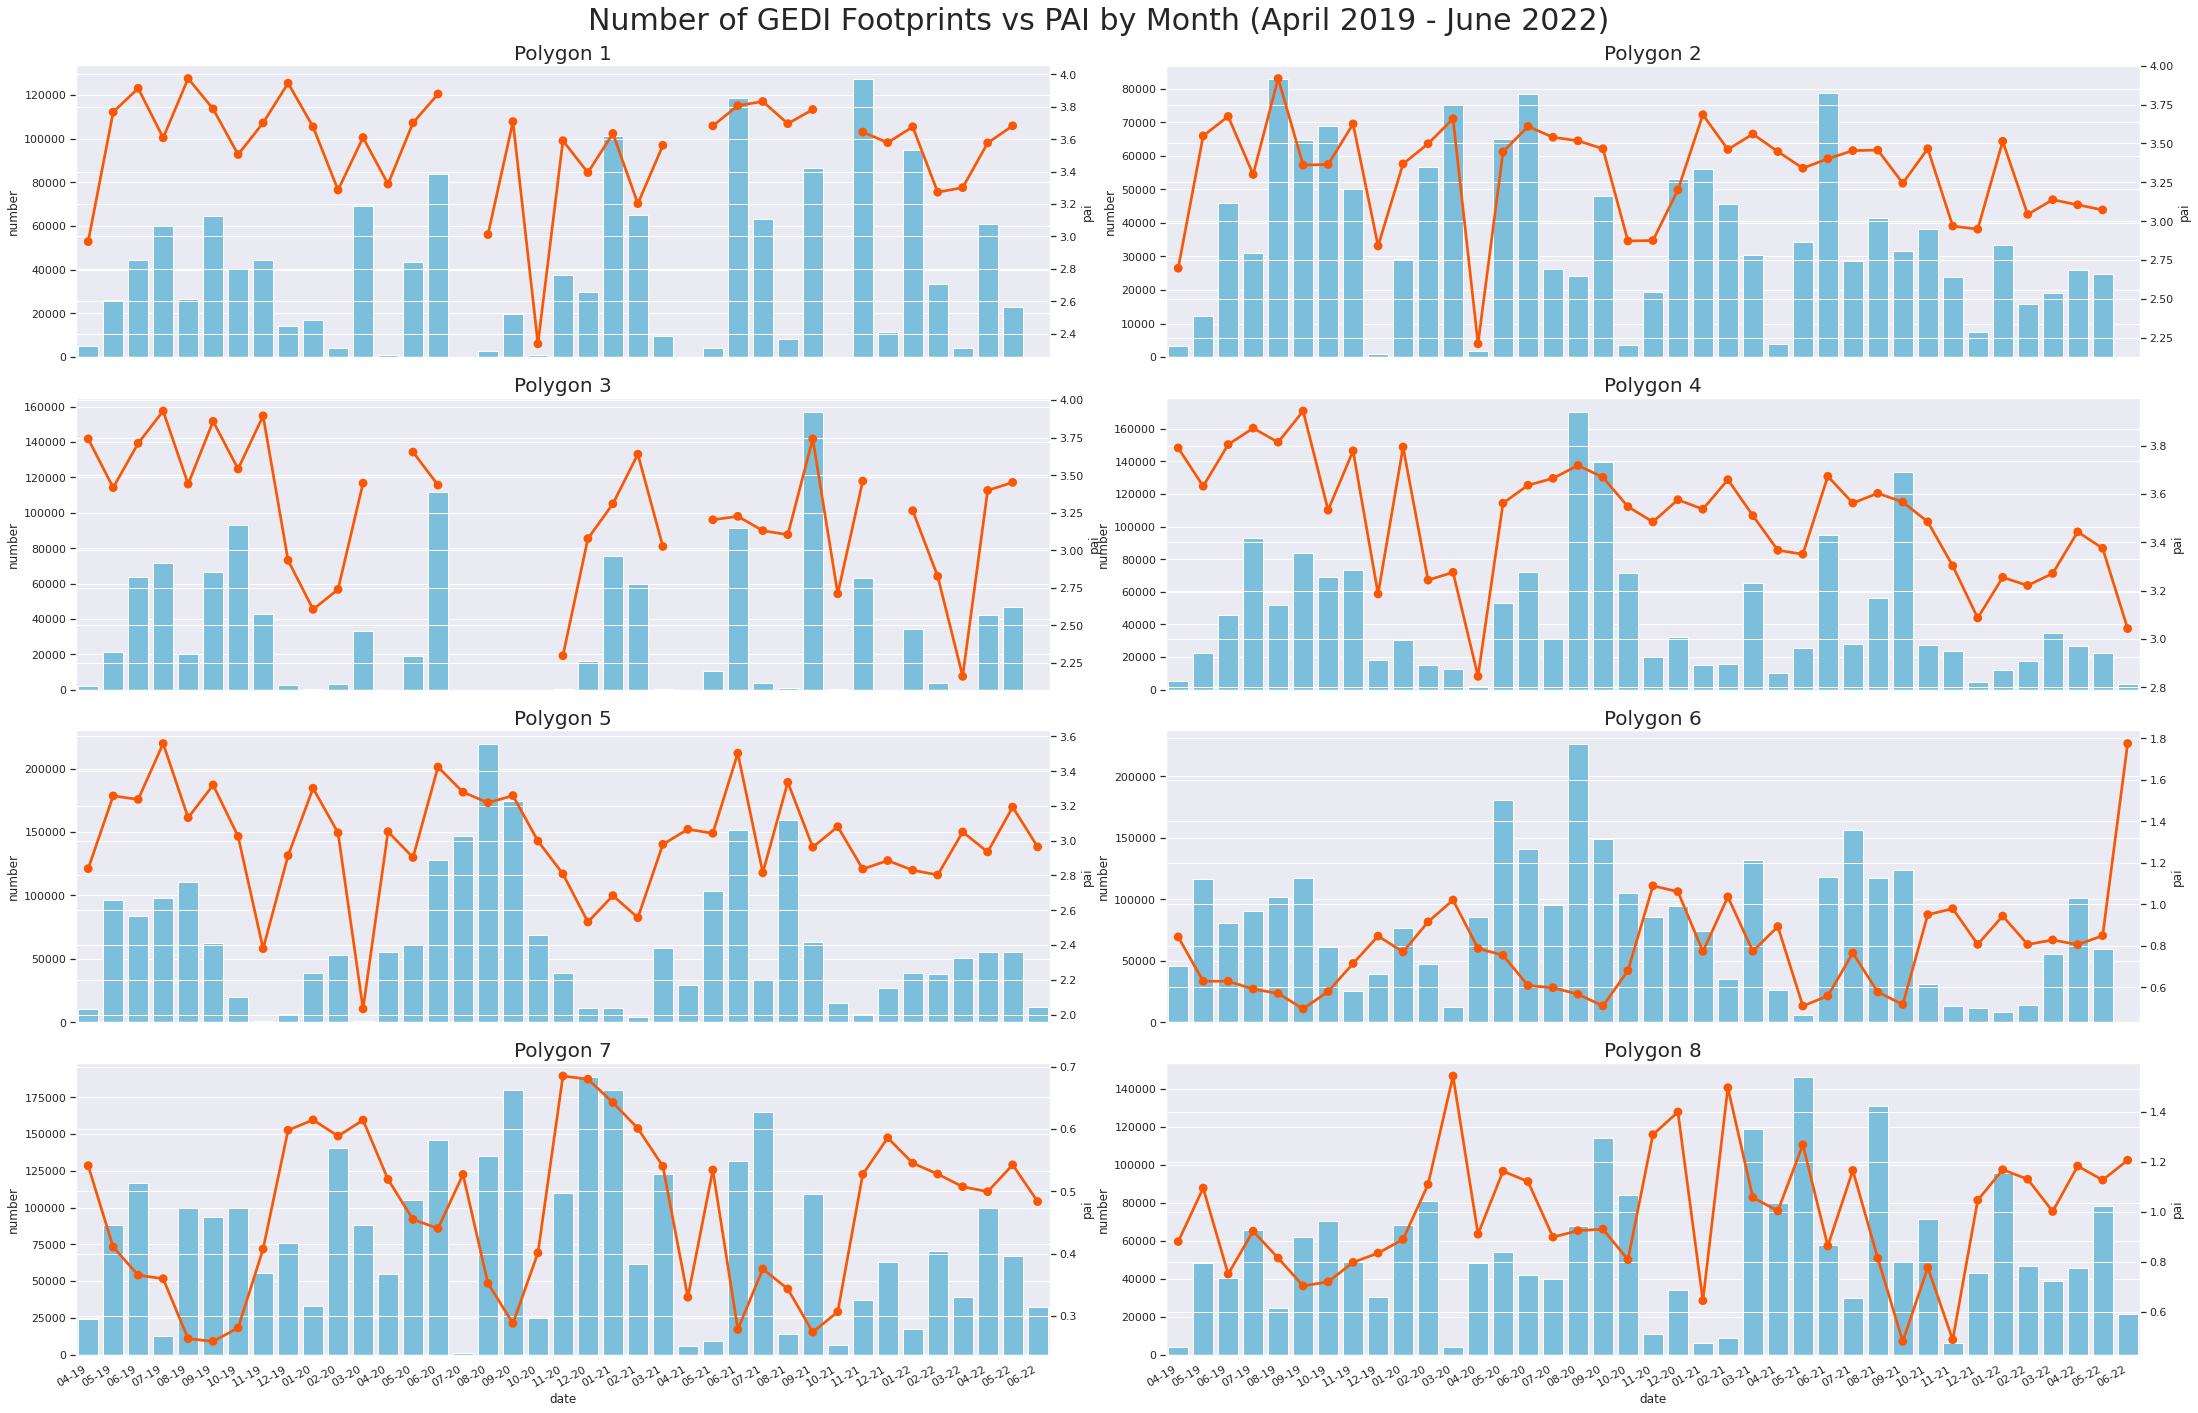

In [13]:
fig, ax = plot.layered_plot_per_polygon(monthly_filled, 
                                        x='date',
                                        bar_y='number',
                                        line_y='pai',
                                        title="Number of GEDI Footprints vs PAI by Month (April 2019 - June 2022)") # noqa: E501

fig.autofmt_xdate()

### Plot Individual months

In [33]:
def plot_one_month_data(df, polygon_id, month, year, x_lim_max=6):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'Footprints for polygon {polygon_id}. Date: {month}-{year}', fontsize=20)
    one_month_data = df.loc[(df.polygon_id == polygon_id)&(df.month==month)&(df.year==year)]
    sns.scatterplot(x=one_month_data.lon_lowestmode, y=one_month_data.lat_lowestmode, ax=ax[0])
    sns.histplot(one_month_data.pai, ax=ax[1])
    ax[1].set_xlim(0,x_lim_max)
    plt.axvline(one_month_data.pai.mean(), c='red', ls='-', lw=2.5)
    plt.axvline(one_month_data.pai.median(), c='orange', ls='--', lw=2.5)
    plt.show()
    return one_month_data

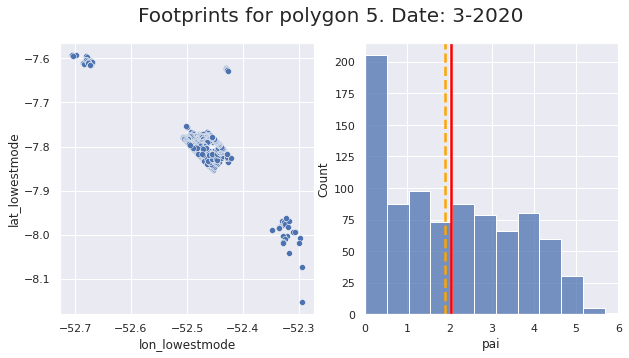

In [34]:
data = plot_one_month_data(footprints, 5, 3, 2020)

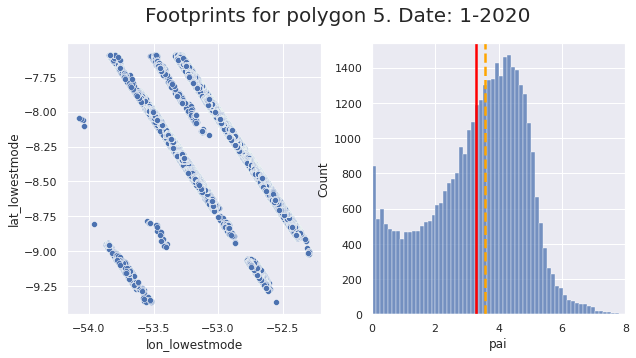

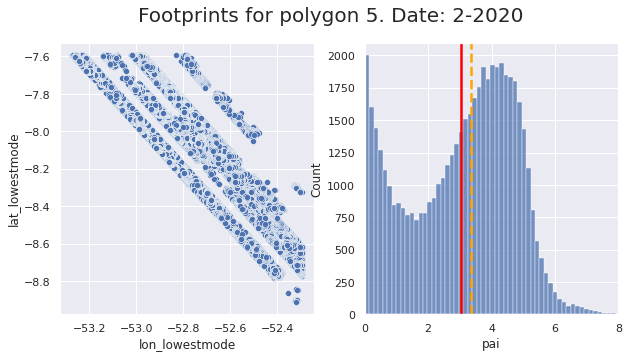

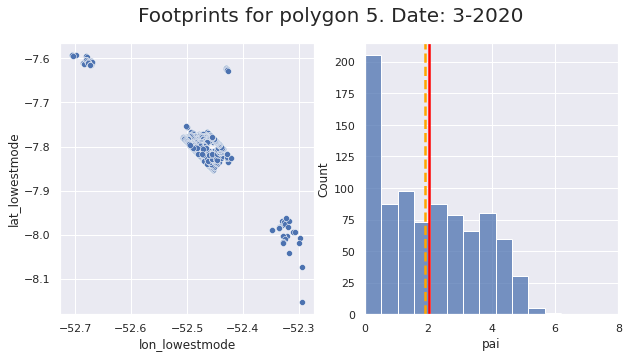

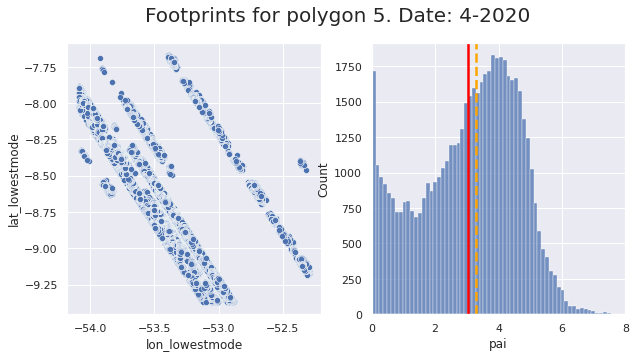

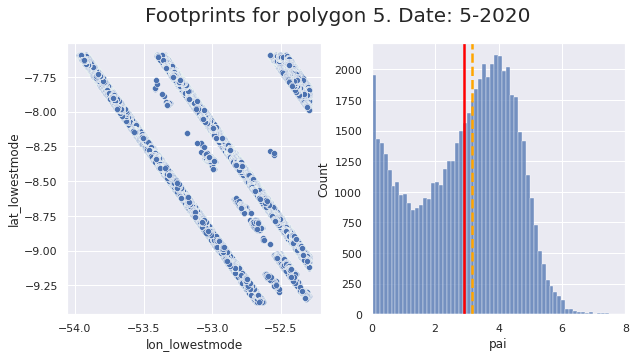

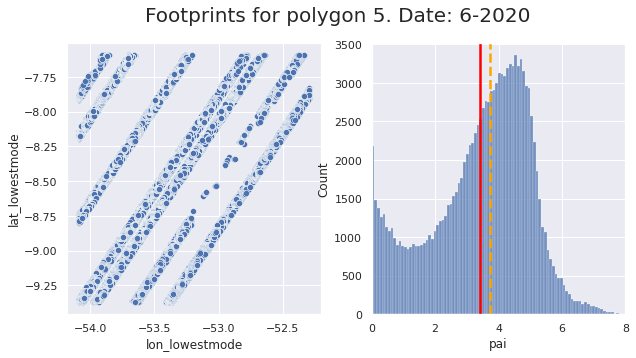

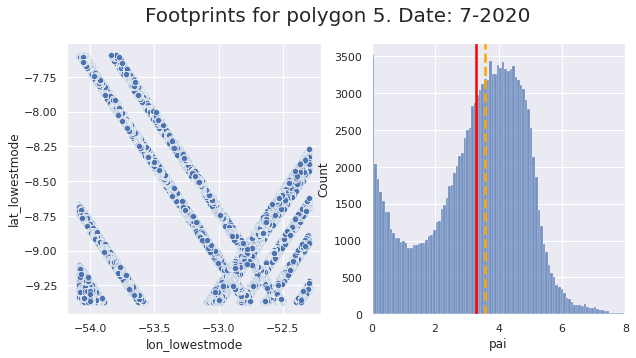

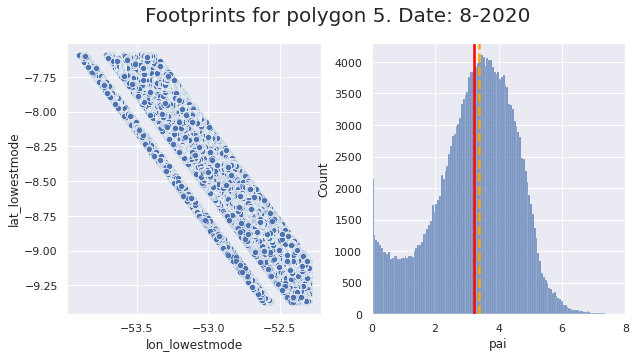

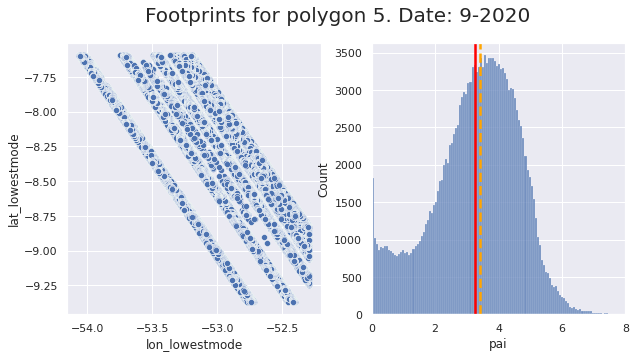

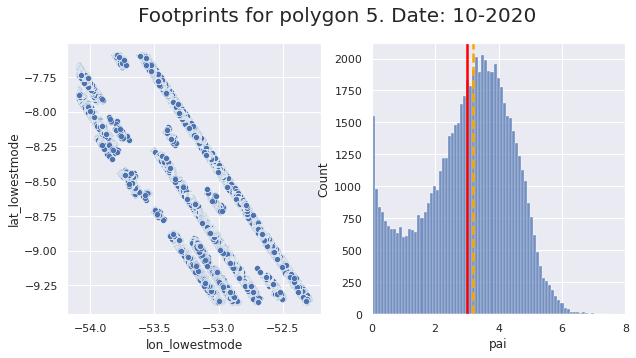

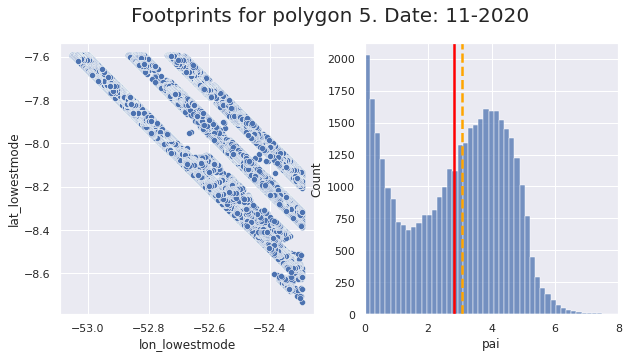

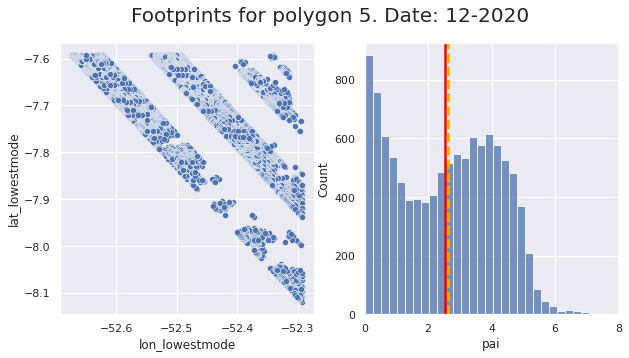

In [35]:
# Plot all months for a given year and a given polygon
year = 2020
for month in range(1, 13):
    plot_one_month_data(footprints, 5, month, year, x_lim_max=8)